In [642]:
import nltk
import emoji
import string
import numpy as np
import pandas as pd
from scipy import stats
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import CategoricalNB,GaussianNB,MultinomialNB
from sklearn.model_selection import cross_validate,GridSearchCV,train_test_split
plt.style.use('dark_background')

My goal was to see how well I could predict sentiment analysis on Roman Urdu (Urdu written using the Roman alphabet). The data contains 20229 text records, each labeled with one of the following sentiments: 'Positive',
'Neutral','Negative'. The data only had one missing value for text, which was dropped. There was also some typos in the label column that had to be corrected.

Each sample text was tokenized and cleared of stop words. (List of urdu stop words obtained from https://github.com/haseebelahi/roman-urdu-stopwords/). Because the data is text-based, a multinomial naive bayes classifier was chosen -- which is trained using the frequency of word occurances. This modeling method is known to work well for sentiment analysis and is capable of multiclass problems.

After iterating through smoothing parameters (from 0 to 100), the model found the optimal alpha to be 1 (Laplace smoothing). The model had 80% accuracy on the test set and dropped to 61% on the test set, indicating overfitting was an issue. Initially the vecorizor discared emoticons, so I created another feature matrix that converted emojis to text (unfortunately in English). This model performed best with a smoothing parameter of 1 as well but did not improve on the prior model's accuracy. Because this model is based off of word frequency it may be beneficial to translate these emoticons into Urdu rather than English so that they are factored into non-emoji word frequencies.

In [663]:
X = pd.read_csv('Roman Urdu DataSet.csv',header=None,names=['urdu','sentiment','null'])[['urdu','sentiment']]
print(X.shape)
X.head(5)

(20229, 2)


,urdu,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


### Target sentiments

In [664]:
print(X.sentiment.unique())
X.sentiment[X.sentiment=='Neative'] = 'Negative'
print(X.sentiment.unique())

['Positive' 'Neutral' 'Negative' 'Neative']
['Positive' 'Neutral' 'Negative']


### Drop missing values

In [665]:
print(X[pd.isna(X.urdu)])
X = X[pd.notna(X.urdu)]

      urdu sentiment
16904  NaN   Neutral


### Stop Words

In [666]:
stop_words = set(['ai','ayi','hy','hai','main','ki','tha','koi','ko','sy','woh' ,'bhi','aur','wo','yeh','rha',
                  'hota','ho','ga','ka','le','lye' ,'kr','kar','lye','liye','hotay','waisay','gya','gaya','kch',
                  'ab','thy','thay','houn','hain','han','to','is','hi','jo','kya','thi','se','pe','phr','wala',
                  'waisay','us','na','ny','hun','rha','raha','ja','rahay','abi','uski','ne','haan','acha','nai',
                  'sent','photo','you','kafi','gai','rhy','kuch','jata','aye','ya','dono','hoa','aese','de',
                  'wohi','jati','jb','krta','lg','rahi','hui','karna','krna','gi','hova','yehi','jana','jye',
                  'chal','mil','tu','hum','par','hay','kis','sb','gy','dain','krny','tou'] + 
                  list(string.punctuation) + ['’','”','“','--'])

### Vectorize Text

In [667]:
vectorizer = TfidfVectorizer(lowercase=True,stop_words=stop_words)
X_vex = vectorizer.fit_transform(X.urdu)
len(vectorizer.get_feature_names())

32116

### Grid Search

In [668]:
X_train,X_test,y_train,y_test = train_test_split(X_vex,X.sentiment,test_size=0.3)

parameters = {'alpha':[a for a in range(0,100)], 
              'fit_prior':[True,False]}
bayes      = MultinomialNB()
grid       = GridSearchCV(bayes,parameters,cv=10)
results    = grid.fit(X_train,y_train)

print(grid.best_params_)
print(grid.best_score_)

{'alpha': 1, 'fit_prior': True}
0.6105657203888921


### Best Model

In [669]:
bayes = MultinomialNB(alpha=1)
model = bayes.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

print(f'Training Set Accuracy:\n\t {accuracy_score(y_train, y_train_pred)}')
print(f'Test Set Accuracy:\n\t {accuracy_score(y_test, y_test_pred)}')

Training Set Accuracy:
	 0.8081079172257928
Test Set Accuracy:
	 0.6197067062118965


### Train/Test Accuracy by Alpha Levels

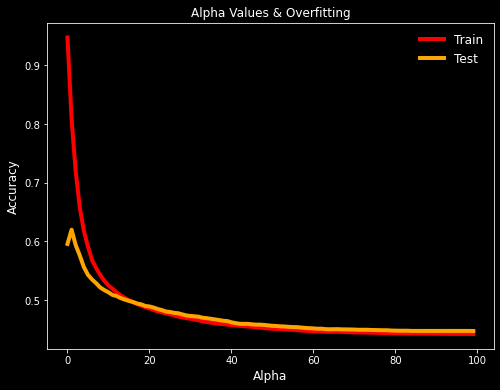

In [670]:
alphas = list(range(0,100))
test_scores = []
train_scores = []

for a in alphas:
    bayes = MultinomialNB(alpha=a)
    model = bayes.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train_scores.append(accuracy_score(y_train, y_train_pred))
    test_scores.append(accuracy_score(y_test, y_test_pred))

fig, ax = plt.subplots(figsize=(8,6))

plt.plot(alphas,train_scores,color='red',linewidth=4.0,label='Train')
plt.plot(alphas,test_scores,color='orange',linewidth=4.0,label='Test')
plt.xlabel('Alpha',fontsize='large')
plt.ylabel('Accuracy',fontsize='large')
plt.title('Alpha Values & Overfitting')
ax.legend(frameon=False,fontsize='large')
plt.show()

### Including emojis in analysis

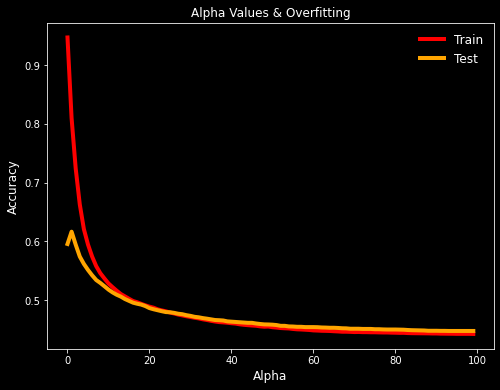

In [671]:
X.urdu = X.urdu.map(emoji.demojize)

vectorizer = TfidfVectorizer(lowercase=True,stop_words=stop_words)
X_vex = vectorizer.fit_transform(X.urdu)

X_train,X_test,y_train,y_test = train_test_split(X_vex,X.sentiment,test_size=0.3)

alphas = list(range(0,100))
test_scores = []
train_scores = []

for a in alphas:
    bayes = MultinomialNB(alpha=a)
    model = bayes.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train_scores.append(accuracy_score(y_train, y_train_pred))
    test_scores.append(accuracy_score(y_test, y_test_pred))
    
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(alphas,train_scores,color='red',linewidth=4.0,label='Train')
plt.plot(alphas,test_scores,color='orange',linewidth=4.0,label='Test')
plt.xlabel('Alpha',fontsize='large')
plt.ylabel('Accuracy',fontsize='large')
plt.title('Alpha Values & Overfitting')
ax.legend(frameon=False,fontsize='large')
plt.show()

### Best Model

In [672]:
bayes = MultinomialNB(alpha=1)
model = bayes.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

print(f'Training Set Accuracy:\n\t {accuracy_score(y_train, y_train_pred)}')
print(f'Test Set Accuracy:\n\t {accuracy_score(y_test, y_test_pred)}')

Training Set Accuracy:
	 0.8095204463592062
Test Set Accuracy:
	 0.6164112703905091
